Something has to be wrong with what plastid is doing here, the total counts for ribosome profiling reads from that table are greater then the total number of counts for the original data itself! The whole thing seems... backwards. And the RNA seq counts from the table are like, 30 times smaller than the one from the dataset?

## Importing packages and defining the path

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, GenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
import plastid
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr

In [5]:
# Define the path to our Bam files
data_path = "/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/dmel/"
save_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TE_tables/dmel/"
p_site_path = "/home/keeganfl/Desktop/Work_Fall_2021/data_tables/p-site_offsets/dmel/"
gtf_name = "Drosophila_melanogaster.BDGP6.32.103.gtf"
mutation = 'control'
samp_num = '3'
special = "fc"

## Loading in the data

In [6]:
# Load up genome annotation as a list of transcript objects
gtf_reads=list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [7]:
# Open the read alignments, storing each dataset in a BAMGenomeArray:
my_datasets = { "ribosome_profiling" : data_path + mutation +"_RPF_" + samp_num + "_Aligned.sortedByCoord.out.bam"
              }

my_datasets = { K : BAMGenomeArray(V) for K,V in my_datasets.items() }

In [8]:
for tr in gtf_reads:
    if tr.attr["transcript_biotype"] == "protein_coding":
        if tr.attr["gene_name"] == "sqd":
            print(gtf_reads.index(tr))
            my_transcript = tr

27499
27500
27501
27502
27503


In [9]:
# Load in the table of P-site offsets. 
p_offsets=pd.read_csv(p_site_path + RPF_name + "_Aligned.toTranscriptome.out_p-site-offsets", sep="\t")

# Map the ribosome profiling alignments to the p-site. 
my_datasets["ribosome_profiling"].set_mapping(kat.VariableThreePrimeMapFactory(p_offsets=p_offsets))

NameError: name 'RPF_name' is not defined

In [ ]:
# we will calculate both total counts and RPKM
metrics = ("counts","rpk","lengths")

# create an empty list for each sample and metric
my_data = { "%s_%s" % (SAMPLE,METRIC) : copy.deepcopy([])\
                                                  for SAMPLE in my_datasets.keys()\
                                                  for METRIC in metrics }

# add a list to our dictionary of lists to store transcript IDs
my_data["transcript_ID"] = []
my_data["gene_name"] = []
my_data["gene_ID"] = []

for transcript in gtf_reads:
        
    # First, save ID of transcript we are evaluating
    if transcript.attr["transcript_biotype"] == "protein_coding":
        my_data["transcript_ID"].append(transcript.get_name())
        my_data["gene_ID"].append(transcript.attr["gene_id"])
        my_data["gene_name"].append(transcript.attr["gene_name"])

        # Iterate over each sample
        for sample_name, sample_data in my_datasets.items():
            # transcript.get_counts() fetches a list of counts at each position
            # here we just want the sum
            counts = sum(transcript.get_counts(sample_data))
            rpk   = float(counts)/(transcript.length/1000)
            lengths = transcript.length
            my_data["%s_counts" % (sample_name)].append(counts)
            my_data["%s_rpk"   % (sample_name)].append(rpk)
            my_data["%s_lengths" % (sample_name)].append(lengths)

In [ ]:
# convert to Dataframe
df = pd.DataFrame(my_data)

In [593]:
len(feature_counts)

23932

## Loading RNA sequencing data from feature counts

In [594]:
feature_counts = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/counts_control_RNA_3_original.txt', delimiter = "\t", comment='#')

In [595]:
cols = ["Geneid","Length","control_RNA_3_Aligned.sortedByCoord.out.bam"]
feature_counts = feature_counts[cols]

In [596]:
feature_counts.rename(columns = {"control_RNA_3_Aligned.sortedByCoord.out.bam" : "RNA-seq_counts",
                                "Length" : "RNA-seq_lengths", "Geneid" : "gene_ID"}, inplace = True)

In [597]:
df_merged = pd.merge(feature_counts, df, how = "inner", on = "gene_ID")

In [598]:
df_merged

,gene_ID,RNA-seq_lengths,RNA-seq_counts,ribosome_profiling_counts,ribosome_profiling_rpk,ribosome_profiling_lengths,transcript_ID,gene_name
0,FBgn0267431,6519,3,2.000000,0.306796,6519,FBtr0392909,Myo81F
1,FBgn0267430,6490,0,0.645161,0.099409,6490,FBtr0445191,Pzl
2,FBgn0086917,1767,0,1.730769,0.979496,1767,FBtr0300207,spok
3,FBgn0010247,3112,8579,934.000000,300.128535,3112,FBtr0113885,Parp
4,FBgn0086378,1290,3465,495.000000,383.720930,1290,FBtr0301810,Alg-2
...,...,...,...,...,...,...,...,...
30705,FBgn0040038,2905,0,0.000000,0.000000,2779,FBtr0113686,klhl10
30706,FBgn0040038,2905,0,0.000000,0.000000,2706,FBtr0113685,klhl10
30707,FBgn0085692,1428,0,2.040000,1.428571,1428,FBtr0347010,CG41561
30708,FBgn0259817,615,0,0.000000,0.000000,615,FBtr0300105,SteXh:CG42398


In [599]:
df = df_merged

# Estimating and plotting translation efficiency

Translation efficiency can be estimated by normalizing an mRNA’s translating ribosome density (in TPM, as measured by ribosome profiling) by the mRNA’s abundance (in TPM, measured by RNA-Seq) ([IGNW09]).

Making this estimate from the calculations above is simple:

In [600]:
df["RNA-seq_rpk"] = df["RNA-seq_counts"]/(df["RNA-seq_lengths"]/1000)

# Calculate tpm using rpk from our new dataframe. 
for sample_name in ["RNA-seq", "ribosome_profiling"]:
    per_m_s = sum(df["%s_rpk"   % (sample_name)])/1e6
    df["%s_tpm" % (sample_name)] = (df["%s_rpk"   % (sample_name)])/per_m_s
    
# Calculate rpkm using the read counts. Work in progress.
for sample_name in ["RNA-seq", "ribosome_profiling"]:
    counts = df["%s_counts"   % (sample_name)]
    rpkm   = counts / df["%s_lengths" % (sample_name)]*1000 * 1e6 / sum(counts)
    df["%s_rpkm" % (sample_name)] = rpkm
    
    
# Calculate translation efficiency using tpm
df["TE_tpm"] = df["ribosome_profiling_tpm"] / df["RNA-seq_tpm"]

# Calculate translation efficiency using rpkm
df["TE_rpkm"] = df["ribosome_profiling_rpkm"] / df["RNA-seq_rpkm"]

In [601]:
# Rearranging Column names to make something more readable. 
cols = ['transcript_ID', "gene_ID","gene_name", 'TE_tpm','TE_rpkm','ribosome_profiling_tpm',
        'RNA-seq_tpm','ribosome_profiling_counts','RNA-seq_counts',
        'ribosome_profiling_rpkm', 'RNA-seq_rpkm', 'ribosome_profiling_rpk', 
       'RNA-seq_rpk', 'ribosome_profiling_lengths', 'RNA-seq_lengths']
df = df[cols]

In [602]:
df

,transcript_ID,gene_ID,gene_name,TE_tpm,TE_rpkm,ribosome_profiling_tpm,RNA-seq_tpm,ribosome_profiling_counts,RNA-seq_counts,ribosome_profiling_rpkm,RNA-seq_rpkm,ribosome_profiling_rpk,RNA-seq_rpk,ribosome_profiling_lengths,RNA-seq_lengths
0,FBtr0392909,FBgn0267431,Myo81F,8.611876,13.291509,0.078052,0.009063,2.000000,3,0.044172,0.003323,0.306796,0.460193,6519,6519
1,FBtr0445191,FBgn0267430,Pzl,inf,inf,0.025291,0.000000,0.645161,0,0.014313,0.000000,0.099409,0.000000,6490,6490
2,FBtr0300207,FBgn0086917,spok,inf,inf,0.249195,0.000000,1.730769,0,0.141027,0.000000,0.979496,0.000000,1767,1767
3,FBtr0113885,FBgn0010247,Parp,1.406369,2.170580,76.356054,54.293050,934.000000,8579,43.212362,19.908212,300.128535,2756.748072,3112,3112
4,FBtr0301810,FBgn0086378,Alg-2,1.845402,2.848180,97.622893,52.900611,495.000000,3465,55.247955,19.397631,383.720930,2686.046512,1290,1290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30705,FBtr0113686,FBgn0040038,klhl10,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,2779,2905
30706,FBtr0113685,FBgn0040038,klhl10,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,2706,2905
30707,FBtr0347010,FBgn0085692,CG41561,inf,inf,0.363445,0.000000,2.040000,0,0.205685,0.000000,1.428571,0.000000,1428,1428
30708,FBtr0300105,FBgn0259817,SteXh:CG42398,NaN,NaN,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,615,615


In [530]:
# save the data frame.
df.to_csv(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv", index = False)

In [ ]:
#!# A line of code that quickly loads up the data if it has already been saved. 
df = pd.read_csv(save_path + mutation + '_' + samp_num + '_' + "te_table" + special + ".csv")

The data above can now be easily plotted in many different ways. For example, the table below shows the correlation between the transcript levels and the translation levels

In [515]:
df[df["gene_name"] == "Hsp26"]

,transcript_ID,gene_ID,gene_name,TE_tpm,TE_rpkm,ribosome_profiling_tpm,RNA-seq_tpm,ribosome_profiling_counts,RNA-seq_counts,ribosome_profiling_rpkm,RNA-seq_rpkm,ribosome_profiling_rpk,RNA-seq_rpk,ribosome_profiling_lengths,RNA-seq_lengths
14357,FBtr0076496,FBgn0001225,Hsp26,1.869123,2.884792,2672.269457,1429.691445,10062.585205,73319,1512.323766,524.240212,10503.742385,72593.069307,958,1010
14358,FBtr0346539,FBgn0001225,Hsp26,1.772891,2.736268,2534.687267,1429.691445,10062.585205,73319,1434.461552,524.240212,9962.955649,72593.069307,1010,1010


Text(0, 0.5, 'Translation (tpm of footprints over CDS)')

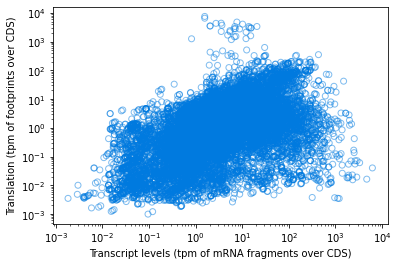

In [60]:
my_figure = plt.figure()
plt.loglog() # log-scaling makes it easier

# make a copy of dataframe for plotting
# this is because 0-values cannot be plotted in log-space,
# so we set them to a pseudo value called `MIN_VAL`

MIN_VAL = np.nan
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_tpm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_tpm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_tpm"],
            plot_df["ribosome_profiling_tpm"],
            marker="o",alpha=0.5,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (tpm of mRNA fragments over CDS)")
plt.ylabel("Translation (tpm of footprints over CDS)")

## Distribution of translation efficiency

In [603]:
df_clean=df[~df.isin([np.nan, np.inf, -np.inf, 0]).any(1)]
df_interest=df_clean[(df_clean["TE_tpm"] >= 0)&(df_clean["TE_tpm"] <= 800)]

(0.0, 20.0)

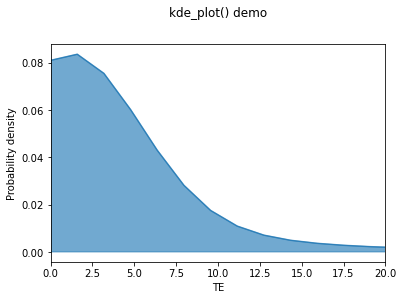

In [604]:
# plot kernel density estimates of A and B on the same axis
fig, ax = kde_plot(df_interest["TE_tpm"],label="TE")

# make things look nice
plt.xlabel("TE")
plt.ylabel("Probability density")
plt.title("kde_plot() demo",y=1.1)
plt.xlim(0,20)

Then, we can compare the effects of transcriptional and translational control:

<module 'matplotlib.pyplot' from '/home/keeganfl/miniconda3/envs/plastid/lib/python3.8/site-packages/matplotlib/pyplot.py'>

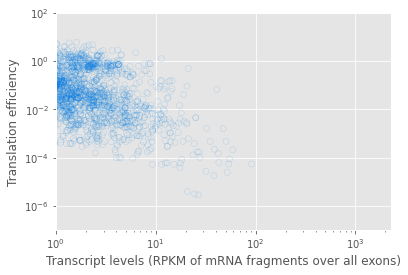

In [56]:
plt.loglog()
plot_df = copy.deepcopy(df)
plot_df["RNA-seq_rpkm"].replace({0:MIN_VAL}, inplace=True)
plot_df["ribosome_profiling_rpkm"].replace({0:MIN_VAL}, inplace=True)

# now, make a scatter plot
plt.scatter(plot_df["RNA-seq_rpkm"],
            plot_df["TE_tpm"],
            marker="o",alpha=0.2,facecolor="none",edgecolor="#007ADF")
plt.xlabel("Transcript levels (RPKM of mRNA fragments over all exons)")
plt.ylabel("Translation efficiency")
plt.xlim(1,plt.xlim()[1])
plt.ylim(plt.ylim()[0]/10.0,100)

plt